In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit,SubCircuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Logging.Logging import setup_logging
from multiprocessing import Pool
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import random
setup_logging()

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

In [2]:
def generate_mn_range(M_start, M_end, N_start, N_end):
    special_mn = []
    for m in range(M_start, M_end+1):
        for n in range(N_start, N_end+1):
            special_mn.append((m, n))
    return special_mn

In [3]:
M = 364
N = 91
w = 0.0025
l = 0.0025

In [4]:
def create_tandem_array(M, N, special_mn):
    circuit = Circuit('Perovskite/Silicon Tandem Equivalent Circuit')
    
    circuit.model('D1_top', 'D', IS = 8.8e-23*(w*l), N =1)
    circuit.model('D2_top', 'D', IS = 2.62e-13*(w*l), N =2)
    circuit.model('D1_bot', 'D', IS=1.3339e-14*(w*l), N =1)
    circuit.model('D2_bot', 'D', IS=6.5674e-19*(w*l), N =2)
    circuit.V('1', 'input', circuit.gnd, 0@u_V)

    for m in range(M):
        for n in range(N):
            name_prefix = f"{m:03d}{n:03d}"
            is_special = (m, n) in special_mn
            print(f"Processing m={m}, n={n}, is_special={is_special}")
            
            # Metal Sheet Resistance
            if m == 0:
                circuit.R(f'Metal_sheet_input{n:03d}', 'input', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
            if ( m == 1 and 0 < n < 91) or (m > 1 and  n == 45):
                circuit.R(f'Metal_sheet_v{m:03d}{n:03d}', f'q{m-1:03d}{n:03d}', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
                circuit.R(f'Metal_sheet_h{m:03d}{n:03d}', f'q{m:03d}{n-1:03d}', f'q{m:03d}{n:03d}', 2.13*w/l@u_mOhm)
                circuit.R(f'c_metal_{name_prefix}', f'q{m:03d}{n:03d}', f'a{m:03d}{n:03d}', 5/(w*l)@u_mOhm)            
            
                
            # ITO Sheet Resistance
            
            if m > 0:
                circuit.R(f'ITO_sheet_v{m:03d}{n:03d}', f'a{m-1:03d}{n:03d}', f'a{m:03d}{n:03d}', 55*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'ITO_sheet_h{m:03d}{n:03d}', f'a{m:03d}{n-1:03d}', f'a{m:03d}{n:03d}', 55*w/l@u_Ohm)

            # RJ Sheet Resistance
            if m > 0:
                circuit.R(f'RJ_sheet_v{m:03d}{n:03d}', f'd{m-1:03d}{n:02d}', f'd{m:03d}{n:03d}', 200*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'RJ_sheet_h{m:03d}{n:03d}', f'd{m:03d}{n-1:03d}', f'd{m:03d}{n:03d}', 200*w/l@u_Ohm)

            # Top Cell
            if is_special:
                circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
            else:
                circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
            circuit.D(f'1_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D1_top')
            circuit.D(f'2_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D2_top')
            circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
                
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

            # Connection
            circuit.R(f'c_top_{name_prefix}', f'c{m:03d}{n:03d}', f'd{m:03d}{n:03d}', 0/(w*l)@u_mOhm)
            circuit.R(f'c_bot_{name_prefix}', f'd{m:03d}{n:03d}', f'e{m:03d}{n:03d}', 0/(w*l)@u_mOhm)

            # Bottom Cell
            circuit.R(f's_bot_{name_prefix}', f'e{m:03d}{n:03d}', f'f{m:03d}{n:03d}', 0.2/(w*l)@u_Ohm)
            circuit.D(f'1_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D1_bot')
            circuit.D(f'2_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D2_bot')
            circuit.R(f'sh_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, 12/(w*l)@u_kOhm)
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

    return circuit

In [7]:
M_start = 5
M_end = 19
N_start = 71
N_end = 85
special_mn = generate_mn_range(M_start, M_end, N_start, N_end)
circuit = create_tandem_array(M, N, special_mn)

def print_rsh_top_elements(circuit):
    count = 0
    for element in circuit.elements:
        if 's_top' in str(element.name):
            print(element)
            count += 1
    print(f"Total s_top elements: {count}")

print_rsh_top_elements(circuit)


Processing m=0, n=0, is_special=False
Processing m=0, n=1, is_special=False
Processing m=0, n=2, is_special=False
Processing m=0, n=3, is_special=False
Processing m=0, n=4, is_special=False
Processing m=0, n=5, is_special=False
Processing m=0, n=6, is_special=False
Processing m=0, n=7, is_special=False
Processing m=0, n=8, is_special=False
Processing m=0, n=9, is_special=False
Processing m=0, n=10, is_special=False
Processing m=0, n=11, is_special=False
Processing m=0, n=12, is_special=False
Processing m=0, n=13, is_special=False
Processing m=0, n=14, is_special=False
Processing m=0, n=15, is_special=False
Processing m=0, n=16, is_special=False
Processing m=0, n=17, is_special=False
Processing m=0, n=18, is_special=False
Processing m=0, n=19, is_special=False
Processing m=0, n=20, is_special=False
Processing m=0, n=21, is_special=False
Processing m=0, n=22, is_special=False
Processing m=0, n=23, is_special=False
Processing m=0, n=24, is_special=False
Processing m=0, n=25, is_special=Fa

Processing m=31, n=28, is_special=False
Processing m=31, n=29, is_special=False
Processing m=31, n=30, is_special=False
Processing m=31, n=31, is_special=False
Processing m=31, n=32, is_special=False
Processing m=31, n=33, is_special=False
Processing m=31, n=34, is_special=False
Processing m=31, n=35, is_special=False
Processing m=31, n=36, is_special=False
Processing m=31, n=37, is_special=False
Processing m=31, n=38, is_special=False
Processing m=31, n=39, is_special=False
Processing m=31, n=40, is_special=False
Processing m=31, n=41, is_special=False
Processing m=31, n=42, is_special=False
Processing m=31, n=43, is_special=False
Processing m=31, n=44, is_special=False
Processing m=31, n=45, is_special=False
Processing m=31, n=46, is_special=False
Processing m=31, n=47, is_special=False
Processing m=31, n=48, is_special=False
Processing m=31, n=49, is_special=False
Processing m=31, n=50, is_special=False
Processing m=31, n=51, is_special=False
Processing m=31, n=52, is_special=False


Processing m=48, n=13, is_special=False
Processing m=48, n=14, is_special=False
Processing m=48, n=15, is_special=False
Processing m=48, n=16, is_special=False
Processing m=48, n=17, is_special=False
Processing m=48, n=18, is_special=False
Processing m=48, n=19, is_special=False
Processing m=48, n=20, is_special=False
Processing m=48, n=21, is_special=False
Processing m=48, n=22, is_special=False
Processing m=48, n=23, is_special=False
Processing m=48, n=24, is_special=False
Processing m=48, n=25, is_special=False
Processing m=48, n=26, is_special=False
Processing m=48, n=27, is_special=False
Processing m=48, n=28, is_special=False
Processing m=48, n=29, is_special=False
Processing m=48, n=30, is_special=False
Processing m=48, n=31, is_special=False
Processing m=48, n=32, is_special=False
Processing m=48, n=33, is_special=False
Processing m=48, n=34, is_special=False
Processing m=48, n=35, is_special=False
Processing m=48, n=36, is_special=False
Processing m=48, n=37, is_special=False


Processing m=65, n=79, is_special=False
Processing m=65, n=80, is_special=False
Processing m=65, n=81, is_special=False
Processing m=65, n=82, is_special=False
Processing m=65, n=83, is_special=False
Processing m=65, n=84, is_special=False
Processing m=65, n=85, is_special=False
Processing m=65, n=86, is_special=False
Processing m=65, n=87, is_special=False
Processing m=65, n=88, is_special=False
Processing m=65, n=89, is_special=False
Processing m=65, n=90, is_special=False
Processing m=66, n=0, is_special=False
Processing m=66, n=1, is_special=False
Processing m=66, n=2, is_special=False
Processing m=66, n=3, is_special=False
Processing m=66, n=4, is_special=False
Processing m=66, n=5, is_special=False
Processing m=66, n=6, is_special=False
Processing m=66, n=7, is_special=False
Processing m=66, n=8, is_special=False
Processing m=66, n=9, is_special=False
Processing m=66, n=10, is_special=False
Processing m=66, n=11, is_special=False
Processing m=66, n=12, is_special=False
Processing

Processing m=85, n=55, is_special=False
Processing m=85, n=56, is_special=False
Processing m=85, n=57, is_special=False
Processing m=85, n=58, is_special=False
Processing m=85, n=59, is_special=False
Processing m=85, n=60, is_special=False
Processing m=85, n=61, is_special=False
Processing m=85, n=62, is_special=False
Processing m=85, n=63, is_special=False
Processing m=85, n=64, is_special=False
Processing m=85, n=65, is_special=False
Processing m=85, n=66, is_special=False
Processing m=85, n=67, is_special=False
Processing m=85, n=68, is_special=False
Processing m=85, n=69, is_special=False
Processing m=85, n=70, is_special=False
Processing m=85, n=71, is_special=False
Processing m=85, n=72, is_special=False
Processing m=85, n=73, is_special=False
Processing m=85, n=74, is_special=False
Processing m=85, n=75, is_special=False
Processing m=85, n=76, is_special=False
Processing m=85, n=77, is_special=False
Processing m=85, n=78, is_special=False
Processing m=85, n=79, is_special=False


Processing m=101, n=22, is_special=False
Processing m=101, n=23, is_special=False
Processing m=101, n=24, is_special=False
Processing m=101, n=25, is_special=False
Processing m=101, n=26, is_special=False
Processing m=101, n=27, is_special=False
Processing m=101, n=28, is_special=False
Processing m=101, n=29, is_special=False
Processing m=101, n=30, is_special=False
Processing m=101, n=31, is_special=False
Processing m=101, n=32, is_special=False
Processing m=101, n=33, is_special=False
Processing m=101, n=34, is_special=False
Processing m=101, n=35, is_special=False
Processing m=101, n=36, is_special=False
Processing m=101, n=37, is_special=False
Processing m=101, n=38, is_special=False
Processing m=101, n=39, is_special=False
Processing m=101, n=40, is_special=False
Processing m=101, n=41, is_special=False
Processing m=101, n=42, is_special=False
Processing m=101, n=43, is_special=False
Processing m=101, n=44, is_special=False
Processing m=101, n=45, is_special=False
Processing m=101

Processing m=118, n=70, is_special=False
Processing m=118, n=71, is_special=False
Processing m=118, n=72, is_special=False
Processing m=118, n=73, is_special=False
Processing m=118, n=74, is_special=False
Processing m=118, n=75, is_special=False
Processing m=118, n=76, is_special=False
Processing m=118, n=77, is_special=False
Processing m=118, n=78, is_special=False
Processing m=118, n=79, is_special=False
Processing m=118, n=80, is_special=False
Processing m=118, n=81, is_special=False
Processing m=118, n=82, is_special=False
Processing m=118, n=83, is_special=False
Processing m=118, n=84, is_special=False
Processing m=118, n=85, is_special=False
Processing m=118, n=86, is_special=False
Processing m=118, n=87, is_special=False
Processing m=118, n=88, is_special=False
Processing m=118, n=89, is_special=False
Processing m=118, n=90, is_special=False
Processing m=119, n=0, is_special=False
Processing m=119, n=1, is_special=False
Processing m=119, n=2, is_special=False
Processing m=119, n

Processing m=135, n=81, is_special=False
Processing m=135, n=82, is_special=False
Processing m=135, n=83, is_special=False
Processing m=135, n=84, is_special=False
Processing m=135, n=85, is_special=False
Processing m=135, n=86, is_special=False
Processing m=135, n=87, is_special=False
Processing m=135, n=88, is_special=False
Processing m=135, n=89, is_special=False
Processing m=135, n=90, is_special=False
Processing m=136, n=0, is_special=False
Processing m=136, n=1, is_special=False
Processing m=136, n=2, is_special=False
Processing m=136, n=3, is_special=False
Processing m=136, n=4, is_special=False
Processing m=136, n=5, is_special=False
Processing m=136, n=6, is_special=False
Processing m=136, n=7, is_special=False
Processing m=136, n=8, is_special=False
Processing m=136, n=9, is_special=False
Processing m=136, n=10, is_special=False
Processing m=136, n=11, is_special=False
Processing m=136, n=12, is_special=False
Processing m=136, n=13, is_special=False
Processing m=136, n=14, is

Processing m=153, n=31, is_special=False
Processing m=153, n=32, is_special=False
Processing m=153, n=33, is_special=False
Processing m=153, n=34, is_special=False
Processing m=153, n=35, is_special=False
Processing m=153, n=36, is_special=False
Processing m=153, n=37, is_special=False
Processing m=153, n=38, is_special=False
Processing m=153, n=39, is_special=False
Processing m=153, n=40, is_special=False
Processing m=153, n=41, is_special=False
Processing m=153, n=42, is_special=False
Processing m=153, n=43, is_special=False
Processing m=153, n=44, is_special=False
Processing m=153, n=45, is_special=False
Processing m=153, n=46, is_special=False
Processing m=153, n=47, is_special=False
Processing m=153, n=48, is_special=False
Processing m=153, n=49, is_special=False
Processing m=153, n=50, is_special=False
Processing m=153, n=51, is_special=False
Processing m=153, n=52, is_special=False
Processing m=153, n=53, is_special=False
Processing m=153, n=54, is_special=False
Processing m=153

Processing m=167, n=7, is_special=False
Processing m=167, n=8, is_special=False
Processing m=167, n=9, is_special=False
Processing m=167, n=10, is_special=False
Processing m=167, n=11, is_special=False
Processing m=167, n=12, is_special=False
Processing m=167, n=13, is_special=False
Processing m=167, n=14, is_special=False
Processing m=167, n=15, is_special=False
Processing m=167, n=16, is_special=False
Processing m=167, n=17, is_special=False
Processing m=167, n=18, is_special=False
Processing m=167, n=19, is_special=False
Processing m=167, n=20, is_special=False
Processing m=167, n=21, is_special=False
Processing m=167, n=22, is_special=False
Processing m=167, n=23, is_special=False
Processing m=167, n=24, is_special=False
Processing m=167, n=25, is_special=False
Processing m=167, n=26, is_special=False
Processing m=167, n=27, is_special=False
Processing m=167, n=28, is_special=False
Processing m=167, n=29, is_special=False
Processing m=167, n=30, is_special=False
Processing m=167, n

Processing m=183, n=53, is_special=False
Processing m=183, n=54, is_special=False
Processing m=183, n=55, is_special=False
Processing m=183, n=56, is_special=False
Processing m=183, n=57, is_special=False
Processing m=183, n=58, is_special=False
Processing m=183, n=59, is_special=False
Processing m=183, n=60, is_special=False
Processing m=183, n=61, is_special=False
Processing m=183, n=62, is_special=False
Processing m=183, n=63, is_special=False
Processing m=183, n=64, is_special=False
Processing m=183, n=65, is_special=False
Processing m=183, n=66, is_special=False
Processing m=183, n=67, is_special=False
Processing m=183, n=68, is_special=False
Processing m=183, n=69, is_special=False
Processing m=183, n=70, is_special=False
Processing m=183, n=71, is_special=False
Processing m=183, n=72, is_special=False
Processing m=183, n=73, is_special=False
Processing m=183, n=74, is_special=False
Processing m=183, n=75, is_special=False
Processing m=183, n=76, is_special=False
Processing m=183

Processing m=202, n=46, is_special=False
Processing m=202, n=47, is_special=False
Processing m=202, n=48, is_special=False
Processing m=202, n=49, is_special=False
Processing m=202, n=50, is_special=False
Processing m=202, n=51, is_special=False
Processing m=202, n=52, is_special=False
Processing m=202, n=53, is_special=False
Processing m=202, n=54, is_special=False
Processing m=202, n=55, is_special=False
Processing m=202, n=56, is_special=False
Processing m=202, n=57, is_special=False
Processing m=202, n=58, is_special=False
Processing m=202, n=59, is_special=False
Processing m=202, n=60, is_special=False
Processing m=202, n=61, is_special=False
Processing m=202, n=62, is_special=False
Processing m=202, n=63, is_special=False
Processing m=202, n=64, is_special=False
Processing m=202, n=65, is_special=False
Processing m=202, n=66, is_special=False
Processing m=202, n=67, is_special=False
Processing m=202, n=68, is_special=False
Processing m=202, n=69, is_special=False
Processing m=202

Processing m=218, n=34, is_special=False
Processing m=218, n=35, is_special=False
Processing m=218, n=36, is_special=False
Processing m=218, n=37, is_special=False
Processing m=218, n=38, is_special=False
Processing m=218, n=39, is_special=False
Processing m=218, n=40, is_special=False
Processing m=218, n=41, is_special=False
Processing m=218, n=42, is_special=False
Processing m=218, n=43, is_special=False
Processing m=218, n=44, is_special=False
Processing m=218, n=45, is_special=False
Processing m=218, n=46, is_special=False
Processing m=218, n=47, is_special=False
Processing m=218, n=48, is_special=False
Processing m=218, n=49, is_special=False
Processing m=218, n=50, is_special=False
Processing m=218, n=51, is_special=False
Processing m=218, n=52, is_special=False
Processing m=218, n=53, is_special=False
Processing m=218, n=54, is_special=False
Processing m=218, n=55, is_special=False
Processing m=218, n=56, is_special=False
Processing m=218, n=57, is_special=False
Processing m=218

Processing m=236, n=48, is_special=False
Processing m=236, n=49, is_special=False
Processing m=236, n=50, is_special=False
Processing m=236, n=51, is_special=False
Processing m=236, n=52, is_special=False
Processing m=236, n=53, is_special=False
Processing m=236, n=54, is_special=False
Processing m=236, n=55, is_special=False
Processing m=236, n=56, is_special=False
Processing m=236, n=57, is_special=False
Processing m=236, n=58, is_special=False
Processing m=236, n=59, is_special=False
Processing m=236, n=60, is_special=False
Processing m=236, n=61, is_special=False
Processing m=236, n=62, is_special=False
Processing m=236, n=63, is_special=False
Processing m=236, n=64, is_special=False
Processing m=236, n=65, is_special=False
Processing m=236, n=66, is_special=False
Processing m=236, n=67, is_special=False
Processing m=236, n=68, is_special=False
Processing m=236, n=69, is_special=False
Processing m=236, n=70, is_special=False
Processing m=236, n=71, is_special=False
Processing m=236

Processing m=251, n=8, is_special=False
Processing m=251, n=9, is_special=False
Processing m=251, n=10, is_special=False
Processing m=251, n=11, is_special=False
Processing m=251, n=12, is_special=False
Processing m=251, n=13, is_special=False
Processing m=251, n=14, is_special=False
Processing m=251, n=15, is_special=False
Processing m=251, n=16, is_special=False
Processing m=251, n=17, is_special=False
Processing m=251, n=18, is_special=False
Processing m=251, n=19, is_special=False
Processing m=251, n=20, is_special=False
Processing m=251, n=21, is_special=False
Processing m=251, n=22, is_special=False
Processing m=251, n=23, is_special=False
Processing m=251, n=24, is_special=False
Processing m=251, n=25, is_special=False
Processing m=251, n=26, is_special=False
Processing m=251, n=27, is_special=False
Processing m=251, n=28, is_special=False
Processing m=251, n=29, is_special=False
Processing m=251, n=30, is_special=False
Processing m=251, n=31, is_special=False
Processing m=251, 

Processing m=270, n=5, is_special=False
Processing m=270, n=6, is_special=False
Processing m=270, n=7, is_special=False
Processing m=270, n=8, is_special=False
Processing m=270, n=9, is_special=False
Processing m=270, n=10, is_special=False
Processing m=270, n=11, is_special=False
Processing m=270, n=12, is_special=False
Processing m=270, n=13, is_special=False
Processing m=270, n=14, is_special=False
Processing m=270, n=15, is_special=False
Processing m=270, n=16, is_special=False
Processing m=270, n=17, is_special=False
Processing m=270, n=18, is_special=False
Processing m=270, n=19, is_special=False
Processing m=270, n=20, is_special=False
Processing m=270, n=21, is_special=False
Processing m=270, n=22, is_special=False
Processing m=270, n=23, is_special=False
Processing m=270, n=24, is_special=False
Processing m=270, n=25, is_special=False
Processing m=270, n=26, is_special=False
Processing m=270, n=27, is_special=False
Processing m=270, n=28, is_special=False
Processing m=270, n=2

Processing m=287, n=90, is_special=False
Processing m=288, n=0, is_special=False
Processing m=288, n=1, is_special=False
Processing m=288, n=2, is_special=False
Processing m=288, n=3, is_special=False
Processing m=288, n=4, is_special=False
Processing m=288, n=5, is_special=False
Processing m=288, n=6, is_special=False
Processing m=288, n=7, is_special=False
Processing m=288, n=8, is_special=False
Processing m=288, n=9, is_special=False
Processing m=288, n=10, is_special=False
Processing m=288, n=11, is_special=False
Processing m=288, n=12, is_special=False
Processing m=288, n=13, is_special=False
Processing m=288, n=14, is_special=False
Processing m=288, n=15, is_special=False
Processing m=288, n=16, is_special=False
Processing m=288, n=17, is_special=False
Processing m=288, n=18, is_special=False
Processing m=288, n=19, is_special=False
Processing m=288, n=20, is_special=False
Processing m=288, n=21, is_special=False
Processing m=288, n=22, is_special=False
Processing m=288, n=23, is

Processing m=301, n=88, is_special=False
Processing m=301, n=89, is_special=False
Processing m=301, n=90, is_special=False
Processing m=302, n=0, is_special=False
Processing m=302, n=1, is_special=False
Processing m=302, n=2, is_special=False
Processing m=302, n=3, is_special=False
Processing m=302, n=4, is_special=False
Processing m=302, n=5, is_special=False
Processing m=302, n=6, is_special=False
Processing m=302, n=7, is_special=False
Processing m=302, n=8, is_special=False
Processing m=302, n=9, is_special=False
Processing m=302, n=10, is_special=False
Processing m=302, n=11, is_special=False
Processing m=302, n=12, is_special=False
Processing m=302, n=13, is_special=False
Processing m=302, n=14, is_special=False
Processing m=302, n=15, is_special=False
Processing m=302, n=16, is_special=False
Processing m=302, n=17, is_special=False
Processing m=302, n=18, is_special=False
Processing m=302, n=19, is_special=False
Processing m=302, n=20, is_special=False
Processing m=302, n=21, is

Processing m=318, n=63, is_special=False
Processing m=318, n=64, is_special=False
Processing m=318, n=65, is_special=False
Processing m=318, n=66, is_special=False
Processing m=318, n=67, is_special=False
Processing m=318, n=68, is_special=False
Processing m=318, n=69, is_special=False
Processing m=318, n=70, is_special=False
Processing m=318, n=71, is_special=False
Processing m=318, n=72, is_special=False
Processing m=318, n=73, is_special=False
Processing m=318, n=74, is_special=False
Processing m=318, n=75, is_special=False
Processing m=318, n=76, is_special=False
Processing m=318, n=77, is_special=False
Processing m=318, n=78, is_special=False
Processing m=318, n=79, is_special=False
Processing m=318, n=80, is_special=False
Processing m=318, n=81, is_special=False
Processing m=318, n=82, is_special=False
Processing m=318, n=83, is_special=False
Processing m=318, n=84, is_special=False
Processing m=318, n=85, is_special=False
Processing m=318, n=86, is_special=False
Processing m=318

Processing m=337, n=45, is_special=False
Processing m=337, n=46, is_special=False
Processing m=337, n=47, is_special=False
Processing m=337, n=48, is_special=False
Processing m=337, n=49, is_special=False
Processing m=337, n=50, is_special=False
Processing m=337, n=51, is_special=False
Processing m=337, n=52, is_special=False
Processing m=337, n=53, is_special=False
Processing m=337, n=54, is_special=False
Processing m=337, n=55, is_special=False
Processing m=337, n=56, is_special=False
Processing m=337, n=57, is_special=False
Processing m=337, n=58, is_special=False
Processing m=337, n=59, is_special=False
Processing m=337, n=60, is_special=False
Processing m=337, n=61, is_special=False
Processing m=337, n=62, is_special=False
Processing m=337, n=63, is_special=False
Processing m=337, n=64, is_special=False
Processing m=337, n=65, is_special=False
Processing m=337, n=66, is_special=False
Processing m=337, n=67, is_special=False
Processing m=337, n=68, is_special=False
Processing m=337

Processing m=354, n=36, is_special=False
Processing m=354, n=37, is_special=False
Processing m=354, n=38, is_special=False
Processing m=354, n=39, is_special=False
Processing m=354, n=40, is_special=False
Processing m=354, n=41, is_special=False
Processing m=354, n=42, is_special=False
Processing m=354, n=43, is_special=False
Processing m=354, n=44, is_special=False
Processing m=354, n=45, is_special=False
Processing m=354, n=46, is_special=False
Processing m=354, n=47, is_special=False
Processing m=354, n=48, is_special=False
Processing m=354, n=49, is_special=False
Processing m=354, n=50, is_special=False
Processing m=354, n=51, is_special=False
Processing m=354, n=52, is_special=False
Processing m=354, n=53, is_special=False
Processing m=354, n=54, is_special=False
Processing m=354, n=55, is_special=False
Processing m=354, n=56, is_special=False
Processing m=354, n=57, is_special=False
Processing m=354, n=58, is_special=False
Processing m=354, n=59, is_special=False
Processing m=354

Rs_top_068089 a068089 b068089 320000.0Ohm
Rs_top_068090 a068090 b068090 320000.0Ohm
Rs_top_069000 a069000 b069000 320000.0Ohm
Rs_top_069001 a069001 b069001 320000.0Ohm
Rs_top_069002 a069002 b069002 320000.0Ohm
Rs_top_069003 a069003 b069003 320000.0Ohm
Rs_top_069004 a069004 b069004 320000.0Ohm
Rs_top_069005 a069005 b069005 320000.0Ohm
Rs_top_069006 a069006 b069006 320000.0Ohm
Rs_top_069007 a069007 b069007 320000.0Ohm
Rs_top_069008 a069008 b069008 320000.0Ohm
Rs_top_069009 a069009 b069009 320000.0Ohm
Rs_top_069010 a069010 b069010 320000.0Ohm
Rs_top_069011 a069011 b069011 320000.0Ohm
Rs_top_069012 a069012 b069012 320000.0Ohm
Rs_top_069013 a069013 b069013 320000.0Ohm
Rs_top_069014 a069014 b069014 320000.0Ohm
Rs_top_069015 a069015 b069015 320000.0Ohm
Rs_top_069016 a069016 b069016 320000.0Ohm
Rs_top_069017 a069017 b069017 320000.0Ohm
Rs_top_069018 a069018 b069018 320000.0Ohm
Rs_top_069019 a069019 b069019 320000.0Ohm
Rs_top_069020 a069020 b069020 320000.0Ohm
Rs_top_069021 a069021 b069021 3200

Rs_top_214059 a214059 b214059 320000.0Ohm
Rs_top_214060 a214060 b214060 320000.0Ohm
Rs_top_214061 a214061 b214061 320000.0Ohm
Rs_top_214062 a214062 b214062 320000.0Ohm
Rs_top_214063 a214063 b214063 320000.0Ohm
Rs_top_214064 a214064 b214064 320000.0Ohm
Rs_top_214065 a214065 b214065 320000.0Ohm
Rs_top_214066 a214066 b214066 320000.0Ohm
Rs_top_214067 a214067 b214067 320000.0Ohm
Rs_top_214068 a214068 b214068 320000.0Ohm
Rs_top_214069 a214069 b214069 320000.0Ohm
Rs_top_214070 a214070 b214070 320000.0Ohm
Rs_top_214071 a214071 b214071 320000.0Ohm
Rs_top_214072 a214072 b214072 320000.0Ohm
Rs_top_214073 a214073 b214073 320000.0Ohm
Rs_top_214074 a214074 b214074 320000.0Ohm
Rs_top_214075 a214075 b214075 320000.0Ohm
Rs_top_214076 a214076 b214076 320000.0Ohm
Rs_top_214077 a214077 b214077 320000.0Ohm
Rs_top_214078 a214078 b214078 320000.0Ohm
Rs_top_214079 a214079 b214079 320000.0Ohm
Rs_top_214080 a214080 b214080 320000.0Ohm
Rs_top_214081 a214081 b214081 320000.0Ohm
Rs_top_214082 a214082 b214082 3200

Rs_top_345087 a345087 b345087 320000.0Ohm
Rs_top_345088 a345088 b345088 320000.0Ohm
Rs_top_345089 a345089 b345089 320000.0Ohm
Rs_top_345090 a345090 b345090 320000.0Ohm
Rs_top_346000 a346000 b346000 320000.0Ohm
Rs_top_346001 a346001 b346001 320000.0Ohm
Rs_top_346002 a346002 b346002 320000.0Ohm
Rs_top_346003 a346003 b346003 320000.0Ohm
Rs_top_346004 a346004 b346004 320000.0Ohm
Rs_top_346005 a346005 b346005 320000.0Ohm
Rs_top_346006 a346006 b346006 320000.0Ohm
Rs_top_346007 a346007 b346007 320000.0Ohm
Rs_top_346008 a346008 b346008 320000.0Ohm
Rs_top_346009 a346009 b346009 320000.0Ohm
Rs_top_346010 a346010 b346010 320000.0Ohm
Rs_top_346011 a346011 b346011 320000.0Ohm
Rs_top_346012 a346012 b346012 320000.0Ohm
Rs_top_346013 a346013 b346013 320000.0Ohm
Rs_top_346014 a346014 b346014 320000.0Ohm
Rs_top_346015 a346015 b346015 320000.0Ohm
Rs_top_346016 a346016 b346016 320000.0Ohm
Rs_top_346017 a346017 b346017 320000.0Ohm
Rs_top_346018 a346018 b346018 320000.0Ohm
Rs_top_346019 a346019 b346019 3200

CPU times: total: 1h 56min 14s
Wall time: 2h 40min 5s
2023-08-29 20:30:11,315 - matplotlib.legend - legend.WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


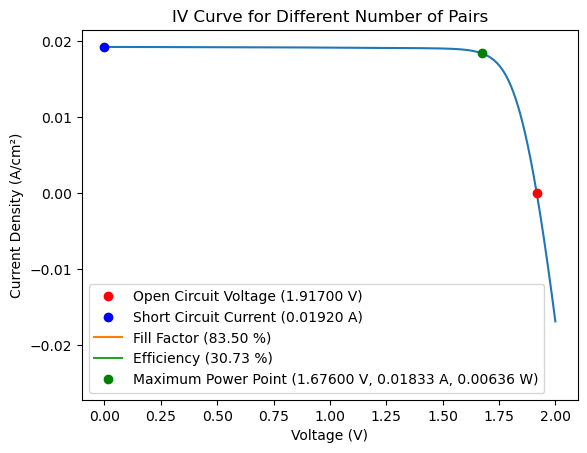

In [8]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
%time analysis = simulator.dc(V1=slice(0, 2, 0.001))
voltage = analysis.nodes['input'].as_ndarray()  # analysis: a dictionary of measured values from nodes and branches
current = analysis.branches['v1'].as_ndarray()  # as_ndarray: converts measured values from a specific node or branch into a numpy array
normalized_current = current / (w * l * M *N)

# Calculate open circuit voltage
v_oc_index = np.argmin(np.abs(normalized_current))  # abs: function that returns the absolute value of a given number
v_oc = voltage[v_oc_index]  # argmin: returns the index of the minimum element in the numpy array

# Calculate short circuit current
i_sc_index = np.argmin(np.abs(voltage))
i_sc = normalized_current[i_sc_index]

# Calculate Maximum Power Point
power = voltage * current
mpp_index = np.argmax(power)
v_mpp = voltage[mpp_index]
i_mpp = normalized_current[mpp_index]
max_power = power[mpp_index]
efficiency = (max_power/(0.1*w*l*M*N))*100

# Calculate Fill Factor
fill_factor = (v_mpp * i_mpp) / (v_oc * i_sc)

plt.plot(voltage, normalized_current)

plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/cm²)')
plt.title('IV Curve for Different Number of Pairs')

# 오픈 회로 전압과 단락 전류 표시
plt.plot(v_oc, 0, 'ro', label=f'Open Circuit Voltage ({v_oc:.5f} V)')
plt.plot(0, i_sc, 'bo', label=f'Short Circuit Current ({i_sc:.5f} A)')
plt.plot(0, -0.025, label=f'Fill Factor ({fill_factor*100:.2f} %)')
plt.plot(0, -0.02, label=f'Efficiency ({efficiency:.2f} %)')
# 최대 전력 지점 표시
plt.plot(v_mpp, i_mpp, 'go', label=f'Maximum Power Point ({v_mpp:.5f} V, {i_mpp:.5f} A, {max_power:.5f} W)')

plt.legend()

plt.show()